In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score, recall_score, f1_score, roc_curve, auc

import pickle
import seaborn as sns

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings("ignore")

In [3]:
# feature_selection_offset_0 = pd.read_csv(f"feature_selection_offset_0.csv")
# feature_selection_offset_1 = pd.read_csv(f"feature_selection_offset_1.csv")
# feature_selection_offset_2 = pd.read_csv(f"feature_selection_offset_2.csv")
feature_selection_offset_3 = pd.read_csv(f"feature_selection_offset_3.csv")
feature_selection_no_sepsis = pd.read_csv(f"feature_selection_no_sepsis.csv")

In [5]:
time_offset = 3

df = pd.concat([feature_selection_offset_3, feature_selection_no_sepsis])

### Separação dos dados

In [7]:
positive_cases = df[df['sepsis'] == 1]
negative_cases = df[df['sepsis'] == 0]

positive_test = positive_cases.sample(n=25, random_state=1)
negative_test = negative_cases.sample(n=25, random_state=1)

positive_train = positive_cases.drop(positive_test.index)
negative_train = negative_cases.drop(negative_test.index).sample(n=60, random_state=42)

df_train = pd.concat([positive_train, negative_train]).sample(frac=1, random_state=42)
df_test = pd.concat([positive_test, negative_test]).sample(frac=1, random_state=42)

### Preencher dados nulos

In [9]:
features = [
    'Systolic pressure Average', 'Systolic pressure Max',
    'Pulse pressure Min', 'Pulse pressure Average', 'Pulse pressure Max',
    'Heart rate Min', 'Heart rate Average', 'Heart rate Max',
    'Temperature Average', 'Temperature Max',
    'Respiration rate Min', 'Respiration rate Average', 'Respiration rate Max',
    'WBC count Min', 'WBC count Average', 'WBC count Max',
    'pH Min', 'pH Average',
    'Blood oxygen saturation Average', 'Blood oxygen saturation Max'
]

for feature in features:
    related_columns = [f"{feature} hour {i}" for i in range(1, 6)]
    
    for i in range(1, 5):
        for col in related_columns:
            df_train[col] = df_train[related_columns].bfill(axis=1).ffill(axis=1)[col]
            df_test[col] = df_test[related_columns].bfill(axis=1).ffill(axis=1)[col]

    for col in related_columns:
        mean_value = df[col].mean()
        df_train[col].fillna(mean_value, inplace=True)
        df_test[col] = df_test[col].fillna(mean_value)

### Arquitetura do trabalho

    - In this research, we used a LSTM architecture with one hidden LSTM layer with 64 one cell memory blocks. The Adam optimization method [41] was used to train the LSTM networks.

In [11]:
X_train = df_train.drop(columns=['sepsis']).values
y_train = df_train['sepsis'].values
X_test = df_test.drop(columns=['sepsis']).values
y_test = df_test['sepsis'].values

In [13]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [15]:
class SepsisNet(nn.Module):
    def __init__(self, input_size=100, hidden_size=64, output_size=2, num_layers=1):
        super(SepsisNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model = SepsisNet()
criterion = nn.CrossEntropyLoss()
lr = 0.00001
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
test_losses = []

num_epochs = 250
patience = 50  
best_loss = float('inf')
stagnant_epochs = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(next(model.parameters()).device), labels.to(next(model.parameters()).device)
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1)) 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(next(model.parameters()).device), labels.to(next(model.parameters()).device)
            outputs = model(inputs.unsqueeze(1)) 
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    if test_loss < best_loss:
        best_loss = test_loss
        stagnant_epochs = 0
    else:
        stagnant_epochs += 1

    if stagnant_epochs >= patience:
        print(f"Parando o treinamento na época {epoch+1} devido à ausência de melhora no test loss por {patience} épocas.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Loss Treino')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Loss Teste')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title(f'Evolução da Loss no Treinamento e Teste - lr: {lr} | epochs: {len(train_losses)}')
plt.legend()
plt.grid()
plt.show()

In [21]:
model.eval()

y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.unsqueeze(1))
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
        y_scores.extend(outputs[:, 1].numpy())

accuracy = sum(np.array(y_true) == np.array(y_pred)) / len(y_true)

auroc = roc_auc_score(y_true, y_scores)
results_df = pd.DataFrame({
        'y_true': y_true,
        'y_scores': y_scores
    })
results_df.to_csv("../resultados/kam_reproducao_original.csv")

conf_matrix = confusion_matrix(y_true, y_pred)

classification_report_str = classification_report(y_true, y_pred, target_names=['Classe 0', 'Classe 1'], digits=4)

sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])

specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])

print(f"Acurácia no conjunto de teste: {accuracy:.4f}")
print(f"AUROC: {auroc:.4f}")
print("Matriz de Confusão:")
print(conf_matrix)
print("Relatório de Classificação:")
print(classification_report_str)
print(f"Sensibilidade (Recall): {sensitivity:.4f}")
print(f"Especificidade: {specificity:.4f}")
print(f"Precisão: {precision:.2f}")

Acurácia no conjunto de teste: 0.7200
AUROC: 0.8288
Matriz de Confusão:
[[19  6]
 [ 8 17]]
Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0     0.7037    0.7600    0.7308        25
    Classe 1     0.7391    0.6800    0.7083        25

    accuracy                         0.7200        50
   macro avg     0.7214    0.7200    0.7196        50
weighted avg     0.7214    0.7200    0.7196        50

Sensibilidade (Recall): 0.6800
Especificidade: 0.7600
Precisão: 0.74


In [36]:
results_df = pd.DataFrame({
        'y_true': y_true,
        'y_scores': y_scores
    })
results_df.to_csv("../resultados/kam_reproducao_original.csv")

In [38]:
results_df

,y_true,y_scores
0,1,0.334918
1,0,-1.230750
2,0,-1.021320
3,0,0.142190
4,1,-0.130409
5,0,-0.531217
6,0,1.360842
7,0,-0.491057
8,0,0.206296
9,1,-0.390904


### Testando diferentes epochs e número de amostras negativas

### Resultados do trabalho

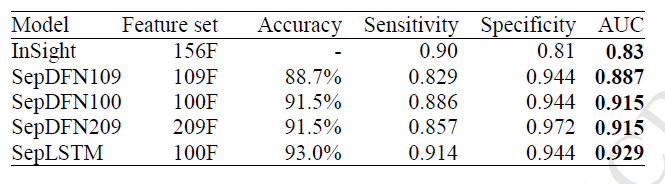

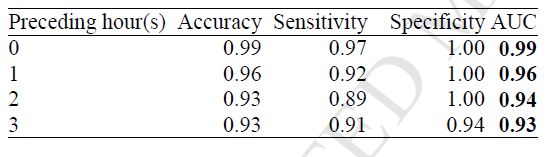

# Conformal Prediction

In [ ]:
def InverseProbabilityNC(predicted_score, y):
    prob = np.zeros(y.size, dtype=np.float32)
    for i, y_ in enumerate(y):
        if y_ >= predicted_score.shape[1]:
            prob[i] = 0
        else:
            prob[i] = predicted_score[i, int(y_)]
    return 1 - prob


def compute_p_value(non_conformity_scores_train, non_conformity_scores_test):
    p_values = []
    if not isinstance(non_conformity_scores_test, list):
        non_conformity_scores_test = [non_conformity_scores_test]

    for test_point_conformity_score in non_conformity_scores_test:
        p_value = (np.sum(non_conformity_scores_train >= test_point_conformity_score) + 1) / (
            len(non_conformity_scores_train) + 1)
        p_values.append(p_value)
    return np.array(p_values)

In [21]:
def prediction_sets(X_train, y_train, X_test, y_test, significance_level=0.05, num_epochs=250, lr = 0.00001):
    prediction_sets = []
    p_values_class_0 = []
    p_values_class_1 = []
    
    for i in range(len(y_test)):
        print(f"Processing sample {i+1}/{len(y_test)}")
        
        X_train_plus_test = np.vstack([X_train, X_test[i].reshape(1, -1)])
        y_train_plus_test_0 = np.append(y_train, 0)
        y_train_plus_test_1 = np.append(y_train, 1)
        
        model_0 = SepsisNet()
        optimizer_0 = optim.Adam(model_0.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        model_1 = SepsisNet()
        optimizer_1 = optim.Adam(model_1.parameters(), lr=lr)
        
        X_tensor_0 = torch.tensor(X_train_plus_test, dtype=torch.float32).unsqueeze(1)
        y_tensor_0 = torch.tensor(y_train_plus_test_0, dtype=torch.long)
        
        X_tensor_1 = torch.tensor(X_train_plus_test, dtype=torch.float32).unsqueeze(1)
        y_tensor_1 = torch.tensor(y_train_plus_test_1, dtype=torch.long)
        
        for epoch in range(num_epochs):
            model_0.train()
            optimizer_0.zero_grad()
            outputs_0 = model_0(X_tensor_0)
            loss_0 = criterion(outputs_0, y_tensor_0)
            loss_0.backward()
            optimizer_0.step()
            
            model_1.train()
            optimizer_1.zero_grad()
            outputs_1 = model_1(X_tensor_1)
            loss_1 = criterion(outputs_1, y_tensor_1)
            loss_1.backward()
            optimizer_1.step()
        
        model_0.eval()
        model_1.eval()
        
        with torch.no_grad():
            y_pred_train_0 = torch.softmax(model_0(X_tensor_0), dim=1).numpy()
            y_pred_train_1 = torch.softmax(model_1(X_tensor_1), dim=1).numpy()
        
        non_conformity_scores_train_0 = InverseProbabilityNC(y_pred_train_0[:-1], y_train_plus_test_0[:-1])
        non_conformity_scores_train_1 = InverseProbabilityNC(y_pred_train_1[:-1], y_train_plus_test_1[:-1])
        
        non_conformity_scores_test_0 = InverseProbabilityNC(y_pred_train_0[-1].reshape(1, -1), np.array([0]))
        non_conformity_scores_test_1 = InverseProbabilityNC(y_pred_train_1[-1].reshape(1, -1), np.array([1]))
        
        p_value_class_0 = compute_p_value(non_conformity_scores_train_0, non_conformity_scores_test_0)
        p_value_class_1 = compute_p_value(non_conformity_scores_train_1, non_conformity_scores_test_1)
        
        p_values_class_0.append(p_value_class_0)
        p_values_class_1.append(p_value_class_1)

        print(f"Sample {i}:    class_0: {p_value_class_0}      class_1: {p_value_class_1}")
        
        if (p_value_class_0 > significance_level) and (p_value_class_1 > significance_level):
            prediction_sets.append([True, True])
        elif (p_value_class_0 > significance_level) and (p_value_class_1 <= significance_level):
            prediction_sets.append([True, False])
        elif (p_value_class_0 <= significance_level) and (p_value_class_1 > significance_level):
            prediction_sets.append([False, True])
        else:
            prediction_sets.append([False, False])

    with open(f'p_values_class_0_{time_offset}_hour.pkl', 'wb') as f:
        pickle.dump(p_values_class_0, f)
    with open(f'p_values_class_1_{time_offset}_hour.pkl', 'wb') as f:
        pickle.dump(p_values_class_1, f)
    
    return prediction_sets, p_values_class_0, p_values_class_1

In [22]:
prediction_sets(X_train, y_train, X_test, y_test)

Processing sample 1/50
Sample 0:    class_0: [0.25663717]      class_1: [0.2300885]
Processing sample 2/50
Sample 1:    class_0: [0.91150442]      class_1: [0.52212389]
Processing sample 3/50
Sample 2:    class_0: [0.44247788]      class_1: [0.30088496]
Processing sample 4/50
Sample 3:    class_0: [0.7699115]      class_1: [0.38938053]
Processing sample 5/50
Sample 4:    class_0: [0.2920354]      class_1: [0.5840708]
Processing sample 6/50
Sample 5:    class_0: [0.32743363]      class_1: [0.08849558]
Processing sample 7/50
Sample 6:    class_0: [1.]      class_1: [1.]
Processing sample 8/50
Sample 7:    class_0: [0.7079646]      class_1: [0.55752212]
Processing sample 9/50
Sample 8:    class_0: [0.40707965]      class_1: [0.20353982]
Processing sample 10/50
Sample 9:    class_0: [0.08849558]      class_1: [0.32743363]
Processing sample 11/50
Sample 10:    class_0: [0.45132743]      class_1: [0.51327434]
Processing sample 12/50
Sample 11:    class_0: [0.44247788]      class_1: [0.433628

([[True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, False],
  [True, True],
  [True, False],
  [True, True],
  [False, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, True],
  [True, False],
  [True, False],
  [True, True],
  [True, True],
  [True, True],
  [True, False],
  [True, True],
  [True, True],
  [True, True],
  [True, False],
  [True, True],
  [False, True],
  [True, True],
  [True, False]],
 [array([0.25663717]),
  array([0.91150442]),
  array([0.44247788]),
  array([0.7699115]),
  array([0.2920354]),
  array([0.32743363]),
  array([1.]),
  array([0.7079646]),
  array([0.407079

In [ ]:
with open(f'p_values_class_0_{time_offset}_hour.pkl', 'rb') as f:
    p_values_test_set_class_0 = pickle.load(f)

with open(f'p_values_class_1_{time_offset}_hour.pkl', 'rb') as f:
    p_values_test_set_class_1 = pickle.load(f)

In [ ]:
def conformal_prediction_metrics(p_values_class_0, p_values_class_1, y_test, significance_level):
    predictions_test_set = []

    for p0, p1 in zip(p_values_class_0, p_values_class_1):
        if (p0 > significance_level) and (p1 > significance_level):
            predictions_test_set.append(0 if p0 > p1 else 1)
        elif (p0 > significance_level) and (p1 <= significance_level):
            predictions_test_set.append(0)
        elif (p0 <= significance_level) and (p1 > significance_level):
            predictions_test_set.append(1)
        else:
            predictions_test_set.append(None)

    valid_indices = [i for i, pred in enumerate(predictions_test_set) if pred is not None]
    invalid_indices = [i for i, pred in enumerate(predictions_test_set) if pred is None]

    # Corrigido: usar iloc para acessar os valores pela posição
    y_test_valid = [y_test[i] for i in valid_indices]
    y_pred_valid = [predictions_test_set[i] for i in valid_indices]

    accuracy = accuracy_score(y_test_valid, y_pred_valid)
    recall = recall_score(y_test_valid, y_pred_valid)
    f1 = f1_score(y_test_valid, y_pred_valid)
    y_score = [1 - p[0] for p in p_values_test_set_class_0]  # ou p_values_class_1

    # Filtrando os mesmos índices válidos
    y_score_valid = [y_score[i] for i in valid_indices]
    
    fpr, tpr, thresholds = roc_curve(y_test_valid, y_score_valid)
    auroc = auc(fpr, tpr)

    conf_matrix = confusion_matrix(y_test_valid, y_pred_valid)
    report = classification_report(y_test_valid, y_pred_valid, digits=4)

    results_df = pd.DataFrame({
        'y_true': [y_test[i] for i in valid_indices],
        'y_pred': [y_score[i] for i in valid_indices]
    })
    #results_df.to_csv('../resultados/kam_cp_original_015.csv')

    coverage_rate = len(valid_indices) / len(y_test)
    set_size = np.mean([
        int(p_values_class_0[i] > significance_level) + int(p_values_class_1[i] > significance_level)
        for i in range(len(y_test))
    ])

    y_test_np = y_test
    removed_sepsis = np.sum(y_test_np[invalid_indices] == 1)
    removed_no_sepsis = np.sum(y_test_np[invalid_indices] == 0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUROC: {auroc:.4f}")
    print(f"Coverage Rate: {coverage_rate:.4f}")
    print(f"Set Size (avg prediction set size): {set_size:.4f}")
    print(f"Removed samples (No sepsis): {removed_no_sepsis}")
    print(f"Removed samples (Sepsis): {removed_sepsis}")
    print("\nClassification Report:")
    print(report)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No sepsis', 'Sepsis'],
                yticklabels=['No sepsis', 'Sepsis'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'recall': recall,
        'f1_score': f1,
        'auroc': auroc,
        'coverage_rate': coverage_rate,
        'set_size': set_size,
        'removed_sepsis': removed_sepsis,
        'removed_no_sepsis': removed_no_sepsis,
        'results_df': results_df
    }


In [ ]:
metrics = conformal_prediction_metrics(
    p_values_class_0=p_values_test_set_class_0,
    p_values_class_1=p_values_test_set_class_1,
    y_test=y_test,  # lista ou array com rótulos verdadeiros
    significance_level=0.05
)

In [46]:
invalid_indices = [i for i, pred in enumerate(predictions_test_set) if pred is None]

y_test_invalid = [list(y_test)[i] for i in invalid_indices]

count_of_ones = y_test_invalid.count(1)

print(f'Número de amostras com sepse na lista: {count_of_ones}')

count_of_zeros = y_test_invalid.count(0)

print(f'Número de amostras sem sepse na lista: {count_of_zeros}')

Número de amostras com sepse na lista: 0
Número de amostras sem sepse na lista: 0


Pode ser que o fato de ter menos dados, o modelo fica muito sucetível a ser tendencioso. Quando assume-se sample = 0 e depois sample = 1 e treina-se o modelo duas vezes, pode ser que ele não consiga computar os erros com efetividade.